## 集成算法

集成已迅速成为应用机器学习中最热门和最流行的方法之一。尤其是在竞赛和提高模型精度方向！

推荐阅读：http://ml-ensemble.com/

<img src="1.png" style="width:800px;height:500px;float:left">

对于数据源X，分别选择两种预处理方案，在不同预处理方案中再建立不同模型，最终汇总所有模型结果

下图代表在 DataFrame 当中 axis 为 0 和 1 时分别代表的含义:

- 使用 0 值表示沿着每一列或行标签\索引值向下执行方法

- 使用 1 值表示沿着每一行或者列标签模向执行对应的方法

<img src="12.png">

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Import data
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

df = pd.read_csv('input.csv')

### Training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=True)
    X.drop(X.columns[X.std() == 0], axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

# A look at the data
print("\nExample data:")
df.head()


Example data:


,cand_pty_affiliation,cand_office_st,cand_office,cand_status,rpt_tp,transaction_tp,entity_tp,state,classification,cycle,transaction_amt
0,REP,US,P,C,Q3,15,IND,NY,Engineer,2016.0,500.0
1,DEM,US,P,C,M5,15E,IND,OR,Math-Stat,2016.0,50.0
2,DEM,US,P,C,M3,15,IND,TX,Scientist,2008.0,250.0
3,DEM,US,P,C,Q2,15E,IND,IN,Math-Stat,2016.0,250.0
4,REP,US,P,C,12G,15,IND,MA,Engineer,2016.0,184.0


* cand_pty_affiliation：我们要预测的指标，共和党或者民主党
* entity_tp：个人还是组织
* classification:领域
* rpt_tp：贡献的大小
* cycle：捐赠在哪年
* transaction_amt：捐献金额


## ROC 与 AUC
<img src="11.png" alt="FAO" width="690" >

<img src="10.png" alt="FAO" width="690" >

接下来我们考虑ROC曲线图中的四个点和一条线。第一个点，(0,1)，即FPR=0, TPR=1，这意味着FN（false negative）=0，并且FP（false positive）=0。Wow，这是一个完美的分类器，它将所有的样本都正确分类。第二个点，(1,0)，即FPR=1，TPR=0，类似地分析可以发现这是一个最糟糕的分类器，因为它成功避开了所有的正确答案。第三个点，(0,0)，即FPR=TPR=0，即FP（false positive）=TP（true positive）=0，可以发现该分类器预测所有的样本都为负样本（negative）。类似的，第四个点（1,1），分类器实际上预测所有的样本都为正样本。经过以上的分析，我们可以断言，ROC曲线越接近左上角，该分类器的性能越好。

下面考虑ROC曲线图中的虚线y=x上的点。这条对角线上的点其实表示的是一个采用随机猜测策略的分类器的结果，例如(0.5,0.5)，表示该分类器随机对于一半的样本猜测其为正样本，另外一半的样本为负样本。

AUC（Area Under Curve）被定义为ROC曲线下的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。使用AUC值作为评价标准是因为很多时候ROC曲线并不能清晰的说明哪个分类器的效果更好，而作为一个数值，对应AUC更大的分类器效果更好。

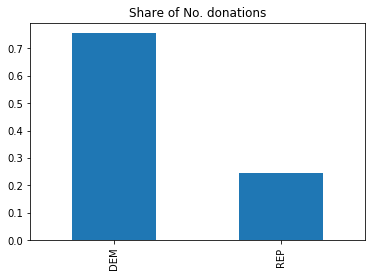

In [3]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(
    kind="bar", title="Share of No. donations")
plt.show()

构建几个基本的决策树模型来看看

In [4]:
import pydotplus  # you can install pydotplus with: pip install pydotplus 
#安装graphviz  http://download.csdn.net/download/shouwangzhelv/9492517
#将安装或者解压的graphviz下的bin目录添加到系统的path中，重启notebook
from IPython.display import Image
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

def print_graph(clf, feature_names):
    """Print decision tree."""
    graph = export_graphviz(
        clf,
        label="root",
        proportion=True,
        impurity=False, 
        out_file=None, 
        feature_names=feature_names,
        class_names={0: "D", 1: "R"},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)  
    return Image(graph.create_png())

Decision tree ROC-AUC score: 0.672


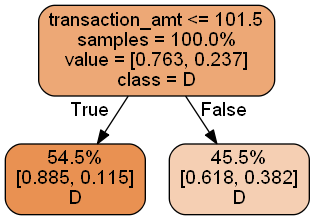

In [5]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t1, xtrain.columns)

看起来这个决策树没啥用，所有的预测结果竟然都是一样的！

Decision tree ROC-AUC score: 0.751


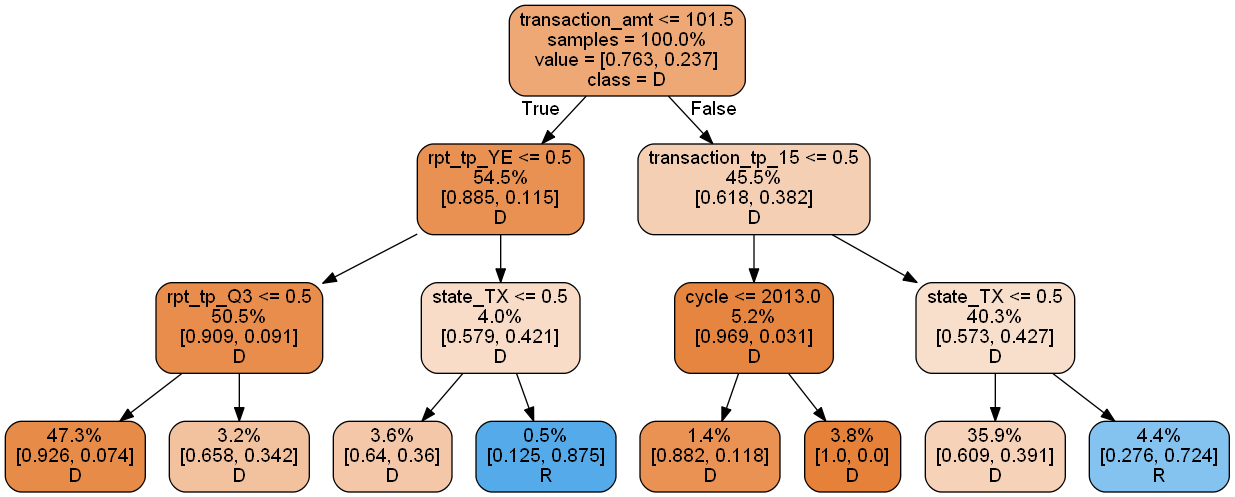

In [6]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]

print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t2, xtrain.columns)

47.3%的样本落到了最左边, 还有35.9% 落在了基本最右边. 这看起来模型基本已经过拟合了。

我们来调整下策略，去掉个对结果有着最大影响的因素再来看看！

Decision tree ROC-AUC score: 0.740


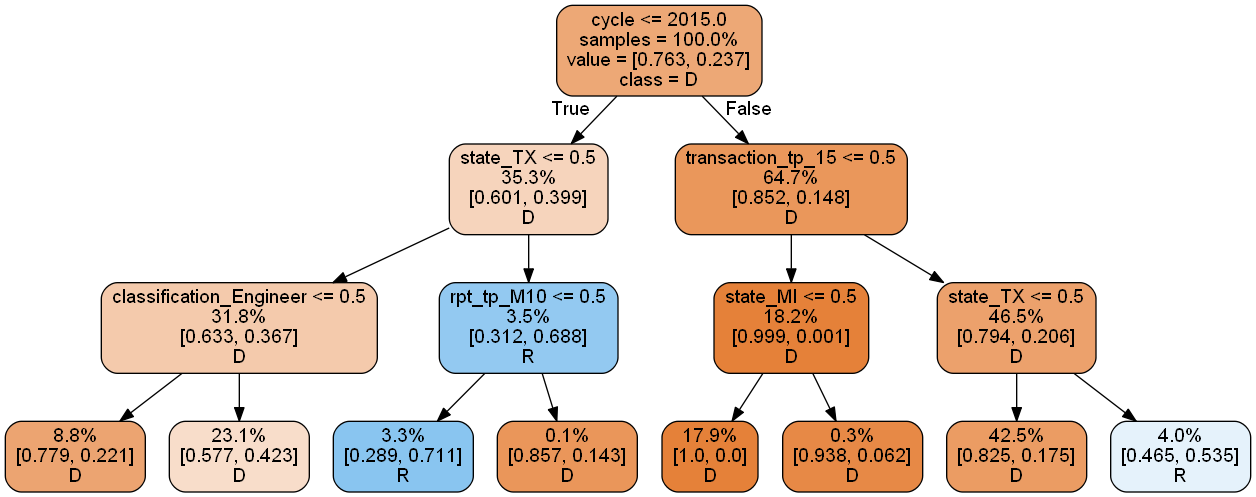

In [7]:
drop = ["transaction_amt"]

xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)

t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]


print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))
print_graph(t3, xtrain_slim.columns)

从这两个树来看，模型的评估结果差不多，但是树看起来很不一样！它们各自都有错误，那我们能不能综合利用它们呢？

<img src="3.png" style="width:400px;height:250px;float:left">
<img src="4.png" style="width:400px;height:250px;float:left">

In [8]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.783


诶呀妈呀，整了个平均还真比原来高了！

这么一说，应该是选择不同的特征会产生不同的结果，然后用不同的结果再进行组合得到了一个升华！那我们多选几组不就是随机森林了嘛！

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


这小分刷的嗖嗖的！

<img src="2.png" style="width:500px;height:350px;float:left">
<img src="5.png" style="width:400px;height:200px;float:left">

来吧兄弟们！一起上了！

In [10]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [11]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done
Done.

Scoring models.
svm                       : 0.850
knn                       : 0.779
naive bayes               : 0.803
mlp-nn                    : 0.851
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.857
Done.



[MLENS] backend: threading


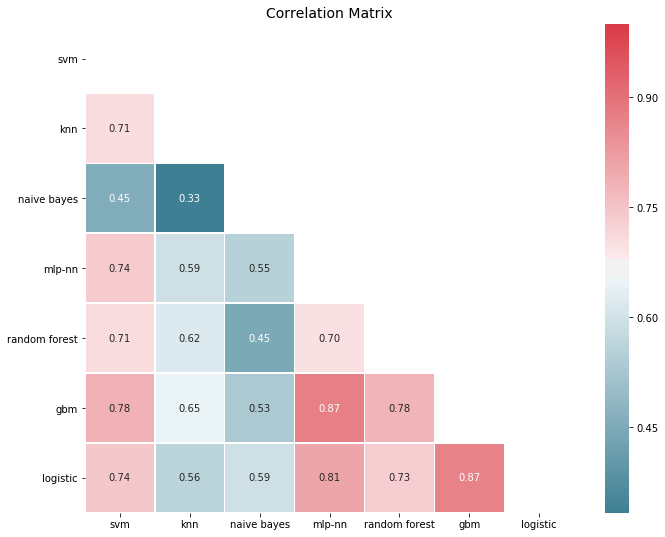

In [12]:
# You need ML-Ensemble for this figure: you can install it with: pip install mlens
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

预测的结果很多都是高度相关的！

In [13]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.884


新纪录诞生了！

<img src="6.png" style="width:500px;height:450px;float:left">

集成算法一方面使得边界更平稳，一方面使得效果更好！

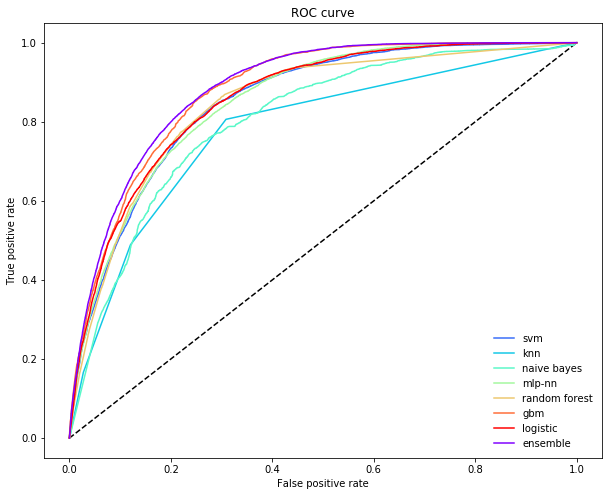

In [14]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

集成算法的曲线是不是更biu特否！

咱们之前的集成都是按照平均来算的，但是这样公平吗？有些拖后腿的咋办呢？

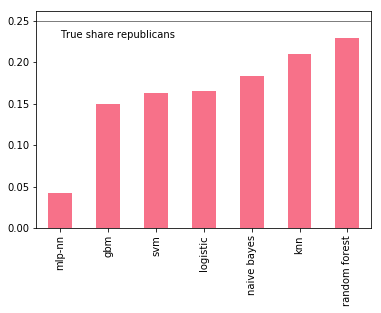

In [15]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

个别模型根本捕捉不到一些类别！这对我们来说是不利的，那集成里面是不是得剔除掉它啊！

把效果最烂的那个给开除了！

In [16]:
include = [c for c in P.columns if c not in ["mlp-nn"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.883


接下来我们得想一个办法，老是自己挑选不是那么个事啊？我能不能让机器自己选择该怎么用这些基础模型呢？

<img src="7.png" style="width:200px;height:100px;float:left">
<img src="8.png" style="width:300px;height:70px;float:left">

对于每一个基础模型，选择一个最合适的权重，但是这些权重我们来怎么定义呢？那就让我们训练一个模型来定义这些权重吧！

在这里我们需要考虑一点？第二个模型的输入应该是什么呢？这需要重点考虑！

# Stacking模型

1.定义我们的基础模型

In [17]:
base_learners = get_models()

2.定义我们的权重分配模型（第二层架构）

In [18]:
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005, 
    random_state=SEED
)

3.将基础模型分成两部分，主要供第二层来使用

In [19]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

4.训练我们的基础模型

In [20]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [21]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


现在已经训练好了基本分类器，但是我们二阶段要求的输入是一阶段木有看过的那些！

<img src="9.png" style="width:400px;height:70px;float:left">

5.准备二阶段权重分配分类器的训练数据

In [22]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [23]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


In [24]:
P_base.shape

(2500, 7)

In [25]:
P_base[0]

array([  6.80512144e-02,   0.00000000e+00,   4.87126290e-52,
         1.06512524e-02,   0.00000000e+00,   1.25337787e-02,
         2.93444590e-03])

6.训练二阶段得出分类结果！

In [26]:
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='exponential', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=222, subsample=0.5, verbose=0,
              warm_start=False)

In [27]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [28]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.881


结果还不错！

划分为训练集和测试集虽然能满足咱们的要求，但是好像损失了一部分数据啊？那怎么办？用交叉验证来搞定！

In [29]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")
    
    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [30]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.889


现在我们来想一想，这样的方法有啥问题呢？是不是速度会比较慢呀！推荐大家用下面的并行方法，速度大大提升！

In [31]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True) 
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:00:43
Processing layer-2             done | 00:00:01
Fit complete                        | 00:00:45

Predicting 2 layers
Processing layer-1             done | 00:00:34
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:36

Super Learner ROC-AUC score: 0.890


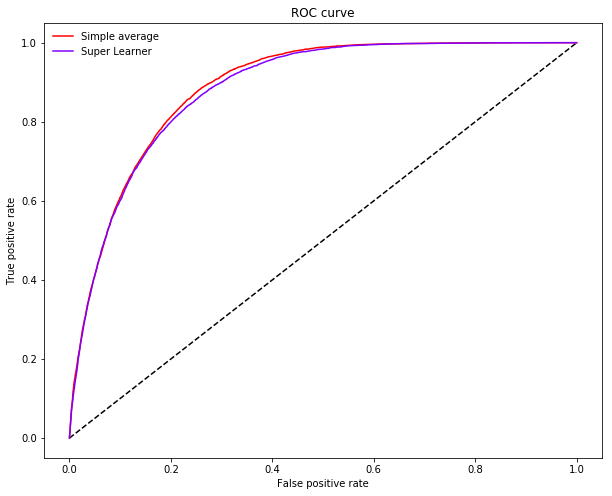

In [32]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")